# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [8]:
!"C:\Program Files\NVIDIA Corporation\NVSMI\nvidia-smi.exe"

Fri Mar 29 22:44:38 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 419.35       Driver Version: 419.35       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1050   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   34C    P8    N/A /  N/A |    885MiB /  2048MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [9]:
import os
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from numba import cuda
cuda.select_device(0)
cuda.close()

import itertools
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [10]:
train, test = keras.datasets.cifar10.load_data()

In [11]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [12]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [13]:
def build_mlp(input_shape=x_train.shape[1:], output_units=y_train.shape[-1], num_neurons=[256, 128, 64, 32]):
    
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation='relu', name='hidden_layers'+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation='relu', name='hidden_layers'+str(i+1))(x)
        
    output_layer = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)

    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    
    return model

In [14]:
# Set your required experiment parameters

optimizers = ['sgd', 'rmsp', 'adag', 'adam']

learning_rates = [1e-2, 1e-3, 1e-4]

epochs = 100

batch_size = 512

In [15]:
def model_fitting(learning_rate, optimizer, epochs, batch_size, input_shape=x_train.shape[1:]):
    
    keras.backend.clear_session()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    sess = tf.Session(config=config)
    
    model = build_mlp(input_shape=input_shape)
    model.summary()
    
    switcher = {'sgd': keras.optimizers.SGD(lr=learning_rate, momentum=0.95, nesterov=True),
                'rmsp': keras.optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=None),
                'adag': keras.optimizers.Adagrad(lr=learning_rate, epsilon=None), 
                'adam': keras.optimizers.Adam(lr=learning_rate, epsilon=None, amsgrad=True)}
    optimizer = switcher.get(optimizer)
    
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    history = model.fit(x_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_data=(x_test, y_test), 
                        shuffle=False,
                        verbose=2)
    
    sess.close()

    return history

In [16]:
results = {}

for learning_rate, optimizer in itertools.product(learning_rates, optimizers):
    
    history = model_fitting(learning_rate=learning_rate,
                            optimizer=optimizer, 
                            epochs=epochs, 
                            batch_size=batch_size)
    
    name_tag = f'{optimizer}, lr={learning_rate}'
    results[name_tag] = {'train_loss': history.history['loss'],
                         'valid_loss': history.history['val_loss'],
                         'train_acc': history.history['acc'],
                         'valid_acc': history.history['val_acc']}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layers1 (Dense)       (None, 256)               786688    
_________________________________________________________________
hidden_layers2 (Dense)       (None, 128)               32896     
_________________________________________________________________
hidden_layers3 (Dense)       (None, 64)                8256      
_________________________________________________________________
hidden_layers4 (Dense)       (None, 32)                2080      
_________________________________________________________________
output (Dense)               (None, 10)                330       
Total params: 830,250
Trainable params: 830,250
Non-trainable params: 0
_________________________________________________________________
Trai

Epoch 84/100
 - 3s - loss: 0.6556 - acc: 0.7612 - val_loss: 2.0316 - val_acc: 0.4958
Epoch 85/100
 - 3s - loss: 0.6638 - acc: 0.7569 - val_loss: 1.9882 - val_acc: 0.4926
Epoch 86/100
 - 3s - loss: 0.6566 - acc: 0.7624 - val_loss: 2.0016 - val_acc: 0.4915
Epoch 87/100
 - 3s - loss: 0.6382 - acc: 0.7699 - val_loss: 2.0348 - val_acc: 0.4907
Epoch 88/100
 - 3s - loss: 0.6211 - acc: 0.7752 - val_loss: 2.0796 - val_acc: 0.4901
Epoch 89/100
 - 3s - loss: 0.6126 - acc: 0.7788 - val_loss: 2.0729 - val_acc: 0.4927
Epoch 90/100
 - 3s - loss: 0.6042 - acc: 0.7815 - val_loss: 2.0896 - val_acc: 0.4951
Epoch 91/100
 - 3s - loss: 0.6107 - acc: 0.7799 - val_loss: 2.1328 - val_acc: 0.4954
Epoch 92/100
 - 3s - loss: 0.6150 - acc: 0.7767 - val_loss: 2.1406 - val_acc: 0.4916
Epoch 93/100
 - 3s - loss: 0.6308 - acc: 0.7695 - val_loss: 2.1203 - val_acc: 0.4891
Epoch 94/100
 - 3s - loss: 0.6419 - acc: 0.7654 - val_loss: 2.0525 - val_acc: 0.4970
Epoch 95/100
 - 3s - loss: 0.6256 - acc: 0.7724 - val_loss: 2.111

 - 3s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 66/100
 - 3s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 67/100
 - 3s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 68/100
 - 4s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 69/100
 - 4s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 70/100
 - 3s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 71/100
 - 4s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 72/100
 - 4s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 73/100
 - 4s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 74/100
 - 4s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 75/100
 - 4s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 76/100
 - 4s - loss: 14.5063 - acc: 0.1000 - val_l

Epoch 47/100
 - 3s - loss: 1.3573 - acc: 0.5201 - val_loss: 1.4609 - val_acc: 0.4891
Epoch 48/100
 - 3s - loss: 1.3525 - acc: 0.5220 - val_loss: 1.4645 - val_acc: 0.4888
Epoch 49/100
 - 3s - loss: 1.3481 - acc: 0.5233 - val_loss: 1.4548 - val_acc: 0.4900
Epoch 50/100
 - 3s - loss: 1.3429 - acc: 0.5247 - val_loss: 1.4514 - val_acc: 0.4921
Epoch 51/100
 - 3s - loss: 1.3386 - acc: 0.5264 - val_loss: 1.4509 - val_acc: 0.4923
Epoch 52/100
 - 3s - loss: 1.3335 - acc: 0.5281 - val_loss: 1.4489 - val_acc: 0.4933
Epoch 53/100
 - 3s - loss: 1.3293 - acc: 0.5293 - val_loss: 1.4438 - val_acc: 0.4947
Epoch 54/100
 - 4s - loss: 1.3241 - acc: 0.5312 - val_loss: 1.4474 - val_acc: 0.4932
Epoch 55/100
 - 3s - loss: 1.3201 - acc: 0.5333 - val_loss: 1.4438 - val_acc: 0.4953
Epoch 56/100
 - 3s - loss: 1.3175 - acc: 0.5338 - val_loss: 1.4439 - val_acc: 0.4944
Epoch 57/100
 - 3s - loss: 1.3119 - acc: 0.5358 - val_loss: 1.4409 - val_acc: 0.4948
Epoch 58/100
 - 3s - loss: 1.3082 - acc: 0.5382 - val_loss: 1.432

Epoch 30/100
 - 4s - loss: 1.5222 - acc: 0.4535 - val_loss: 1.5690 - val_acc: 0.4367
Epoch 31/100
 - 4s - loss: 1.5183 - acc: 0.4557 - val_loss: 1.5624 - val_acc: 0.4387
Epoch 32/100
 - 4s - loss: 1.5119 - acc: 0.4569 - val_loss: 1.5751 - val_acc: 0.4325
Epoch 33/100
 - 4s - loss: 1.5209 - acc: 0.4529 - val_loss: 1.5644 - val_acc: 0.4391
Epoch 34/100
 - 4s - loss: 1.5066 - acc: 0.4572 - val_loss: 1.5642 - val_acc: 0.4399
Epoch 35/100
 - 4s - loss: 1.5244 - acc: 0.4505 - val_loss: 1.5924 - val_acc: 0.4253
Epoch 36/100
 - 4s - loss: 1.5257 - acc: 0.4483 - val_loss: 1.5800 - val_acc: 0.4311
Epoch 37/100
 - 4s - loss: 1.5124 - acc: 0.4546 - val_loss: 1.5906 - val_acc: 0.4284
Epoch 38/100
 - 4s - loss: 1.5129 - acc: 0.4565 - val_loss: 1.5865 - val_acc: 0.4330
Epoch 39/100
 - 3s - loss: 1.5016 - acc: 0.4600 - val_loss: 1.5576 - val_acc: 0.4387
Epoch 40/100
 - 3s - loss: 1.4925 - acc: 0.4654 - val_loss: 1.5656 - val_acc: 0.4351
Epoch 41/100
 - 3s - loss: 1.4964 - acc: 0.4625 - val_loss: 1.589

Epoch 13/100
 - 2s - loss: 1.5505 - acc: 0.4532 - val_loss: 1.5519 - val_acc: 0.4494
Epoch 14/100
 - 2s - loss: 1.5317 - acc: 0.4594 - val_loss: 1.5362 - val_acc: 0.4538
Epoch 15/100
 - 2s - loss: 1.5139 - acc: 0.4654 - val_loss: 1.5223 - val_acc: 0.4573
Epoch 16/100
 - 2s - loss: 1.4971 - acc: 0.4714 - val_loss: 1.5094 - val_acc: 0.4627
Epoch 17/100
 - 2s - loss: 1.4811 - acc: 0.4772 - val_loss: 1.4980 - val_acc: 0.4670
Epoch 18/100
 - 2s - loss: 1.4666 - acc: 0.4823 - val_loss: 1.4878 - val_acc: 0.4699
Epoch 19/100
 - 2s - loss: 1.4522 - acc: 0.4867 - val_loss: 1.4776 - val_acc: 0.4739
Epoch 20/100
 - 2s - loss: 1.4386 - acc: 0.4916 - val_loss: 1.4689 - val_acc: 0.4768
Epoch 21/100
 - 2s - loss: 1.4256 - acc: 0.4955 - val_loss: 1.4609 - val_acc: 0.4808
Epoch 22/100
 - 2s - loss: 1.4130 - acc: 0.4998 - val_loss: 1.4541 - val_acc: 0.4842
Epoch 23/100
 - 2s - loss: 1.4012 - acc: 0.5040 - val_loss: 1.4488 - val_acc: 0.4864
Epoch 24/100
 - 2s - loss: 1.3895 - acc: 0.5079 - val_loss: 1.442

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
 - 3s - loss: 2.3328 - acc: 0.1673 - val_loss: 2.1280 - val_acc: 0.2204
Epoch 2/100
 - 3s - loss: 2.0367 - acc: 0.2571 - val_loss: 2.0742 - val_acc: 0.2544
Epoch 3/100
 - 3s - loss: 1.9213 - acc: 0.3038 - val_loss: 1.9147 - val_acc: 0.3128
Epoch 4/100
 - 3s - loss: 1.8516 - acc: 0.3299 - val_loss: 1.8055 - val_acc: 0.3429
Epoch 5/100
 - 3s - loss: 1.8001 - acc: 0.3489 - val_loss: 1.8643 - val_acc: 0.3300
Epoch 6/100
 - 3s - loss: 1.7584 - acc: 0.3675 - val_loss: 1.7078 - val_acc: 0.3933
Epoch 7/100
 - 3s - loss: 1.7190 - acc: 0.3850 - val_loss: 1.7041 - val_acc: 0.3949
Epoch 8/100
 - 3s - loss: 1.6819 - acc: 0.3994 - val_loss: 1.7408 - val_acc: 0.3844
Epoch 9/100
 - 3s - loss: 1.6548 - acc: 0.4077 - val_loss: 1.6840 - val_acc: 0.4028
Epoch 10/100
 - 3s - loss: 1.6274 - acc: 0.4179 - val_loss: 1.7985 - val_acc: 0.3561
Epoch 11/100
 - 3s - loss: 1.6044 - acc: 0.4272 - val_loss: 1.6098 - val_acc: 0.4238
Epoch 12/100
 - 3s - los

Epoch 97/100
 - 3s - loss: 0.9293 - acc: 0.6673 - val_loss: 1.7968 - val_acc: 0.4837
Epoch 98/100
 - 4s - loss: 0.9172 - acc: 0.6733 - val_loss: 1.8327 - val_acc: 0.4740
Epoch 99/100
 - 3s - loss: 0.9236 - acc: 0.6696 - val_loss: 1.8193 - val_acc: 0.4783
Epoch 100/100
 - 3s - loss: 0.9155 - acc: 0.6734 - val_loss: 1.8819 - val_acc: 0.4562
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layers1 (Dense)       (None, 256)               786688    
_________________________________________________________________
hidden_layers2 (Dense)       (None, 128)               32896     
_________________________________________________________________
hidden_layers3 (Dense)       (None, 64)                8256      
_________________________________________________________________

Epoch 80/100
 - 3s - loss: 1.3723 - acc: 0.5184 - val_loss: 1.4446 - val_acc: 0.4886
Epoch 81/100
 - 3s - loss: 1.3702 - acc: 0.5187 - val_loss: 1.4433 - val_acc: 0.4889
Epoch 82/100
 - 3s - loss: 1.3682 - acc: 0.5197 - val_loss: 1.4422 - val_acc: 0.4881
Epoch 83/100
 - 3s - loss: 1.3662 - acc: 0.5204 - val_loss: 1.4411 - val_acc: 0.4882
Epoch 84/100
 - 2s - loss: 1.3642 - acc: 0.5212 - val_loss: 1.4402 - val_acc: 0.4888
Epoch 85/100
 - 3s - loss: 1.3623 - acc: 0.5223 - val_loss: 1.4385 - val_acc: 0.4902
Epoch 86/100
 - 3s - loss: 1.3604 - acc: 0.5226 - val_loss: 1.4373 - val_acc: 0.4905
Epoch 87/100
 - 3s - loss: 1.3585 - acc: 0.5233 - val_loss: 1.4363 - val_acc: 0.4914
Epoch 88/100
 - 2s - loss: 1.3566 - acc: 0.5235 - val_loss: 1.4352 - val_acc: 0.4916
Epoch 89/100
 - 3s - loss: 1.3547 - acc: 0.5245 - val_loss: 1.4340 - val_acc: 0.4916
Epoch 90/100
 - 3s - loss: 1.3529 - acc: 0.5251 - val_loss: 1.4332 - val_acc: 0.4915
Epoch 91/100
 - 3s - loss: 1.3511 - acc: 0.5260 - val_loss: 1.432

Epoch 63/100
 - 3s - loss: 1.0253 - acc: 0.6348 - val_loss: 1.5131 - val_acc: 0.5105
Epoch 64/100
 - 3s - loss: 1.0212 - acc: 0.6356 - val_loss: 1.5288 - val_acc: 0.4994
Epoch 65/100
 - 3s - loss: 1.0159 - acc: 0.6377 - val_loss: 1.5208 - val_acc: 0.5019
Epoch 66/100
 - 3s - loss: 1.0196 - acc: 0.6342 - val_loss: 1.5488 - val_acc: 0.4974
Epoch 67/100
 - 3s - loss: 1.0312 - acc: 0.6295 - val_loss: 1.5129 - val_acc: 0.4989
Epoch 68/100
 - 3s - loss: 1.0188 - acc: 0.6333 - val_loss: 1.5261 - val_acc: 0.4992
Epoch 69/100
 - 3s - loss: 1.0100 - acc: 0.6368 - val_loss: 1.5782 - val_acc: 0.4893
Epoch 70/100
 - 3s - loss: 1.0084 - acc: 0.6389 - val_loss: 1.5548 - val_acc: 0.4998
Epoch 71/100
 - 3s - loss: 1.0078 - acc: 0.6384 - val_loss: 1.5506 - val_acc: 0.4998
Epoch 72/100
 - 3s - loss: 1.0049 - acc: 0.6400 - val_loss: 1.5397 - val_acc: 0.4990
Epoch 73/100
 - 3s - loss: 1.0090 - acc: 0.6368 - val_loss: 1.5338 - val_acc: 0.5029
Epoch 74/100
 - 3s - loss: 1.0149 - acc: 0.6363 - val_loss: 1.529

Epoch 46/100
 - 3s - loss: 1.7825 - acc: 0.3682 - val_loss: 1.7831 - val_acc: 0.3659
Epoch 47/100
 - 3s - loss: 1.7782 - acc: 0.3699 - val_loss: 1.7789 - val_acc: 0.3681
Epoch 48/100
 - 3s - loss: 1.7739 - acc: 0.3703 - val_loss: 1.7749 - val_acc: 0.3685
Epoch 49/100
 - 3s - loss: 1.7697 - acc: 0.3713 - val_loss: 1.7709 - val_acc: 0.3703
Epoch 50/100
 - 3s - loss: 1.7656 - acc: 0.3728 - val_loss: 1.7670 - val_acc: 0.3723
Epoch 51/100
 - 3s - loss: 1.7616 - acc: 0.3744 - val_loss: 1.7632 - val_acc: 0.3746
Epoch 52/100
 - 3s - loss: 1.7576 - acc: 0.3759 - val_loss: 1.7594 - val_acc: 0.3755
Epoch 53/100
 - 3s - loss: 1.7537 - acc: 0.3779 - val_loss: 1.7556 - val_acc: 0.3774
Epoch 54/100
 - 3s - loss: 1.7498 - acc: 0.3790 - val_loss: 1.7519 - val_acc: 0.3794
Epoch 55/100
 - 3s - loss: 1.7460 - acc: 0.3811 - val_loss: 1.7482 - val_acc: 0.3802
Epoch 56/100
 - 3s - loss: 1.7422 - acc: 0.3827 - val_loss: 1.7445 - val_acc: 0.3806
Epoch 57/100
 - 3s - loss: 1.7384 - acc: 0.3839 - val_loss: 1.740

Epoch 29/100
 - 3s - loss: 1.4375 - acc: 0.4933 - val_loss: 1.4645 - val_acc: 0.4847
Epoch 30/100
 - 3s - loss: 1.4304 - acc: 0.4977 - val_loss: 1.5223 - val_acc: 0.4647
Epoch 31/100
 - 3s - loss: 1.4227 - acc: 0.4994 - val_loss: 1.5386 - val_acc: 0.4579
Epoch 32/100
 - 3s - loss: 1.4164 - acc: 0.4997 - val_loss: 1.4562 - val_acc: 0.4871
Epoch 33/100
 - 3s - loss: 1.4074 - acc: 0.5054 - val_loss: 1.5153 - val_acc: 0.4691
Epoch 34/100
 - 3s - loss: 1.4006 - acc: 0.5076 - val_loss: 1.4911 - val_acc: 0.4779
Epoch 35/100
 - 3s - loss: 1.3937 - acc: 0.5117 - val_loss: 1.5072 - val_acc: 0.4704
Epoch 36/100
 - 3s - loss: 1.3888 - acc: 0.5107 - val_loss: 1.4372 - val_acc: 0.4927
Epoch 37/100
 - 3s - loss: 1.3795 - acc: 0.5152 - val_loss: 1.5039 - val_acc: 0.4714
Epoch 38/100
 - 3s - loss: 1.3756 - acc: 0.5158 - val_loss: 1.4810 - val_acc: 0.4795
Epoch 39/100
 - 3s - loss: 1.3690 - acc: 0.5196 - val_loss: 1.4973 - val_acc: 0.4731
Epoch 40/100
 - 3s - loss: 1.3613 - acc: 0.5238 - val_loss: 1.499

Epoch 12/100
 - 3s - loss: 1.9671 - acc: 0.3036 - val_loss: 1.9628 - val_acc: 0.2991
Epoch 13/100
 - 3s - loss: 1.9588 - acc: 0.3081 - val_loss: 1.9548 - val_acc: 0.3058
Epoch 14/100
 - 3s - loss: 1.9510 - acc: 0.3129 - val_loss: 1.9472 - val_acc: 0.3113
Epoch 15/100
 - 3s - loss: 1.9438 - acc: 0.3171 - val_loss: 1.9402 - val_acc: 0.3154
Epoch 16/100
 - 3s - loss: 1.9370 - acc: 0.3214 - val_loss: 1.9336 - val_acc: 0.3194
Epoch 17/100
 - 3s - loss: 1.9305 - acc: 0.3248 - val_loss: 1.9274 - val_acc: 0.3241
Epoch 18/100
 - 3s - loss: 1.9244 - acc: 0.3291 - val_loss: 1.9214 - val_acc: 0.3288
Epoch 19/100
 - 3s - loss: 1.9186 - acc: 0.3327 - val_loss: 1.9159 - val_acc: 0.3306
Epoch 20/100
 - 3s - loss: 1.9131 - acc: 0.3356 - val_loss: 1.9105 - val_acc: 0.3353
Epoch 21/100
 - 3s - loss: 1.9079 - acc: 0.3387 - val_loss: 1.9054 - val_acc: 0.3379
Epoch 22/100
 - 3s - loss: 1.9029 - acc: 0.3414 - val_loss: 1.9005 - val_acc: 0.3407
Epoch 23/100
 - 3s - loss: 1.8981 - acc: 0.3437 - val_loss: 1.895

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
 - 3s - loss: 2.0373 - acc: 0.2628 - val_loss: 1.9030 - val_acc: 0.3255
Epoch 2/100
 - 3s - loss: 1.8527 - acc: 0.3458 - val_loss: 1.7980 - val_acc: 0.3698
Epoch 3/100
 - 3s - loss: 1.7709 - acc: 0.3768 - val_loss: 1.7340 - val_acc: 0.4006
Epoch 4/100
 - 3s - loss: 1.7143 - acc: 0.3953 - val_loss: 1.6882 - val_acc: 0.4135
Epoch 5/100
 - 4s - loss: 1.6720 - acc: 0.4127 - val_loss: 1.6538 - val_acc: 0.4218
Epoch 6/100
 - 3s - loss: 1.6370 - acc: 0.4237 - val_loss: 1.6271 - val_acc: 0.4285
Epoch 7/100
 - 3s - loss: 1.6079 - acc: 0.4341 - val_loss: 1.6064 - val_acc: 0.4375
Epoch 8/100
 - 3s - loss: 1.5821 - acc: 0.4438 - val_loss: 1.5859 - val_acc: 0.4432
Epoch 9/100
 - 3s - loss: 1.5575 - acc: 0.4528 - val_loss: 1.5649 - val_acc: 0.4489
Epoch 10/100
 - 3s - loss: 1.5354 - acc: 0.4598 - val_loss: 1.5478 - val_acc: 0.4537
Epoch 11/100
 - 3s - loss: 1.5147 - acc: 0.4670 - val_loss: 1.5312 - val_acc: 0.4574
Epoch 12/100
 - 3s - los

Epoch 97/100
 - 3s - loss: 0.9331 - acc: 0.6731 - val_loss: 1.4207 - val_acc: 0.5216
Epoch 98/100
 - 3s - loss: 0.9286 - acc: 0.6746 - val_loss: 1.4216 - val_acc: 0.5221
Epoch 99/100
 - 3s - loss: 0.9245 - acc: 0.6759 - val_loss: 1.4226 - val_acc: 0.5225
Epoch 100/100
 - 3s - loss: 0.9205 - acc: 0.6782 - val_loss: 1.4235 - val_acc: 0.5214


In [19]:
colors = ['#9a0eea', '#15b01a', '#0343df', '#ff81c0', '#653700', 
          '#e50000', '#95d0fc', '#f97306', '#c20078', '#ffff14',
          '#06c2ac', '#00035b', '#d1b26f', '#677a04', '#ae7181', '#ffb07c']

def plotting(results, color_bar=colors):
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 30))
    
    for i, cond in enumerate(results.keys()):

        epochs = range(1, len(results[cond]['train_loss']) + 1)

        ax1.plot(epochs, results[cond]['train_loss'], '-', label=cond, color=color_bar[i])
        ax1.plot(epochs, results[cond]['valid_loss'], '--', label=cond, color=color_bar[i])
        
        ax2.plot(epochs, results[cond]['train_acc'], '-', label=cond, color=color_bar[i])
        ax2.plot(epochs, results[cond]['valid_acc'], '--', label=cond, color=color_bar[i])
        
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_title('Loss', fontsize=25)
    ax1.legend()
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_title('Accuracy', fontsize=25)
    ax2.legend()
    plt.show()

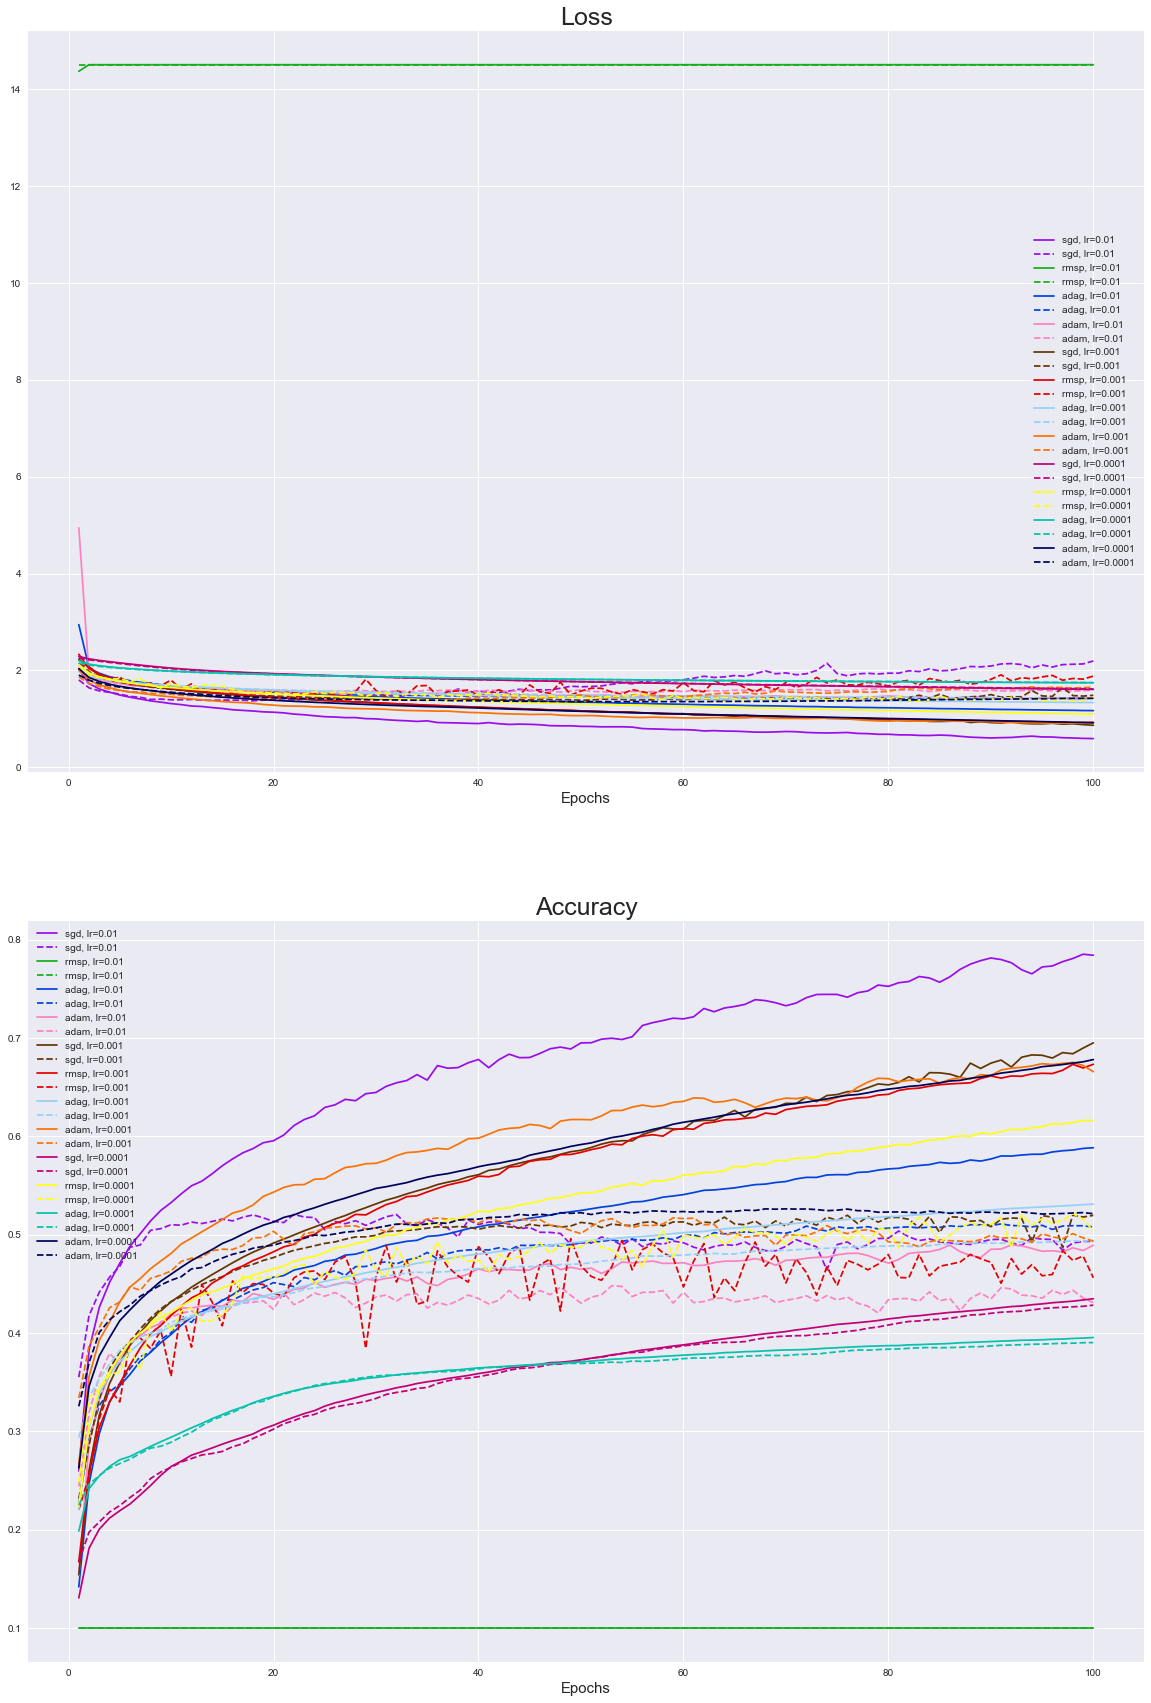

In [20]:
plotting(results)